In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import librosa as lb
from librosa.core import stft, amplitude_to_db
from librosa.display import specshow

In [195]:
files = glob('./files/*.wav')

In [196]:
print(files)

['./files\\Bunlabelledtest__101_1305030823364_A.wav', './files\\Bunlabelledtest__101_1305030823364_D.wav', './files\\Bunlabelledtest__101_1305030823364_F.wav', './files\\Bunlabelledtest__103_1305031931979_A.wav', './files\\Bunlabelledtest__103_1305031931979_C.wav', './files\\Bunlabelledtest__105_1305033453095_B.wav', './files\\Bunlabelledtest__105_1305033453095_D.wav', './files\\Bunlabelledtest__106_1306776721273_B.wav', './files\\Bunlabelledtest__106_1306776721273_D.wav', './files\\Bunlabelledtest__107_1305654946865_B.wav', './files\\Bunlabelledtest__107_1305654946865_D.wav', './files\\Bunlabelledtest__108_1305654420093_C.wav', './files\\Bunlabelledtest__109_1305653646620_B.wav', './files\\Bunlabelledtest__109_1305653646620_D.wav', './files\\Bunlabelledtest__109_1305653972028_B.wav', './files\\Bunlabelledtest__109_1305653972028_D.wav', './files\\Bunlabelledtest__110_1305655332337_D.wav', './files\\Bunlabelledtest__112_1306243000964_C.wav', './files\\Bunlabelledtest__113_1306244002866_

In [197]:
murmur_audio,murmur_freq=lb.load('./files\\MurMur__156_1306936373241_B.wav')
normal_audio,normal_freq=lb.load('./files\\normal__159_1307018640315_B2.wav')

In [198]:
murmur_freq,normal_freq

(22050, 22050)

### In this case, the sampling frequency is 22050, meaning there are 22050 samples per second

In [199]:
murmur_audio.shape

(90797,)

In [200]:
murmur_indices = np.arange(0, len(murmur_audio))
murmur_time = murmur_indices / freq

normal_indices = np.arange(0, len(normal_audio))
normal_time = normal_indices / normal_freq

Text(0,0.5,'Amplification')

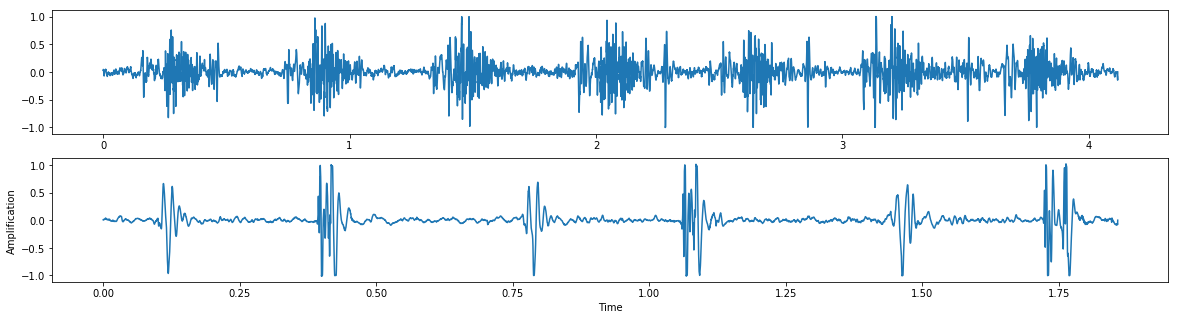

In [201]:
fig,axes=plt.subplots(2,1,figsize=(20,5),sharey=True)
axes[0].plot(murmur_time,murmur_audio)
axes[1].plot(normal_time,normal_audio)
plt.xlabel('Time')
plt.ylabel('Amplification')

In [202]:
normal_means = np.mean(normal_audio,axis=-1)
normal_maxs = np.max(normal_audio)
normal_stds = np.std(normal_audio)


murmur_means = np.mean(murmur_audio)
murmur_maxs = np.max(murmur_audio)
murmur_stds = np.std(murmur_audio)

In [203]:
normal_means.shape

()

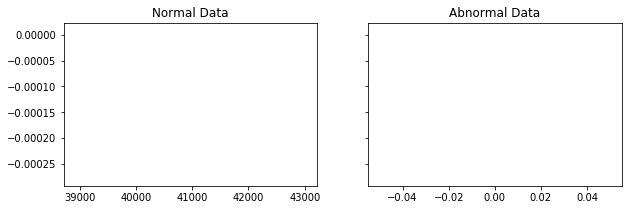

In [204]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax1.plot(normal_time.shape[0], normal_means)
ax1.set(title="Normal Data")
ax2.plot(murmur_time[0], murmur_means)
ax2.set(title="Abnormal Data")
plt.show()

In [205]:
normal_audio_tempo = lb.beat.tempo(normal_audio, sr=normal_freq, 
                            hop_length=2**6, aggregate=None)

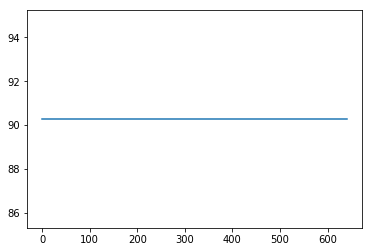

In [206]:
plt.plot(normal_audio_tempo)

In [268]:
audio_half_wave = np.abs(normal_audio)
#audio_half_wave.plot(figsize=(10, 5))
#plt.show()

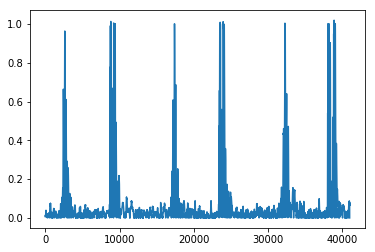

In [269]:
plt.plot(audio_half_wave)

In [270]:
audio_half_wave_series=pd.Series(audio_half_wave)
normal_audio=pd.Series(normal_audio)

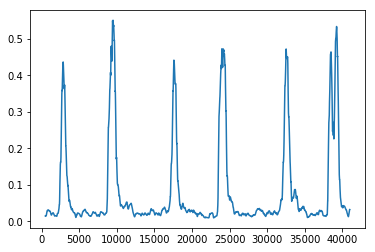

In [271]:
plt.plot(audio_half_wave_series.rolling(500).mean())

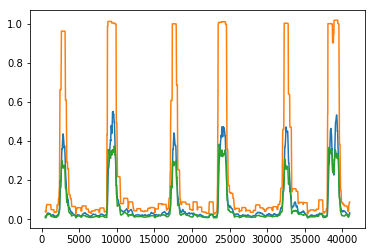

In [272]:
plt.plot(audio_half_wave_series.rolling(500).aggregate([np.mean,np.max,np.std]))

In [273]:
def outlier_detection(audio_half_wave_series):
    abs_difference=audio_half_wave_series-np.mean(audio_half_wave_series)
    mask=abs_difference>(np.std(audio_half_wave_series)*3)
    audio_half_wave_series[mask]=np.nanmedian(audio_half_wave_series)
    plt.plot(audio_half_wave_series)
    #print(audio_half_wave_series[mask])
    #audio_half_wave_series[mask]=np.nanmedian(audio_half_wave_series)
    #return audio_half_wave_series

#audio_half_wave_series.apply(outlier_detection).plot()

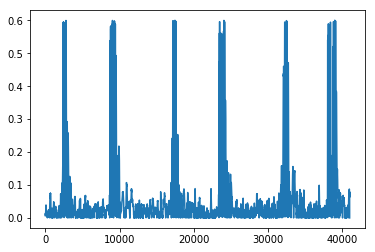

In [274]:
outlier_detection(audio_half_wave_series)

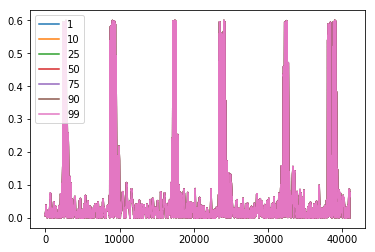

In [275]:
from functools import partial
percentiles=[1, 10, 25, 50, 75, 90, 99]
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]
percent_audio_half_wave_series=audio_half_wave_series.aggregate(percentile_functions)
plt.plot(percent_audio_half_wave_series)
plt.legend(percentiles[:100],loc='best')
plt.figure(figsize=(20,5))

9.313042e-06

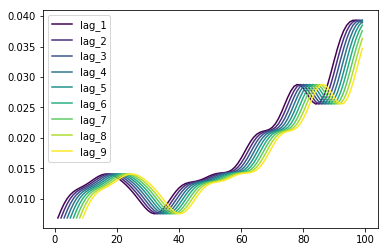

In [276]:
shifts=np.arange(1,10)
many_shifts={'lag_{}'.format(ii):audio_half_wave_series.shift(ii) for ii in shifts}
many_shifts=pd.DataFrame(many_shifts)

many_shifts[:100].plot(cmap=plt.cm.viridis)
#many_shifts.dropna(inplace=True)


#ax = many_shifts.iloc[:100].plot(cmap=plt.cm.viridis)
#many_shifts.iloc[:100].plot(color='r', lw=2)
#ax.legend(loc='best')
#plt.show()

In [287]:
many_shifts=many_shifts.fillna(np.nanmedian(many_shifts))

In [289]:
from sklearn.linear_model import Ridge
model=Ridge()
model.fit(many_shifts,audio_half_wave_series)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

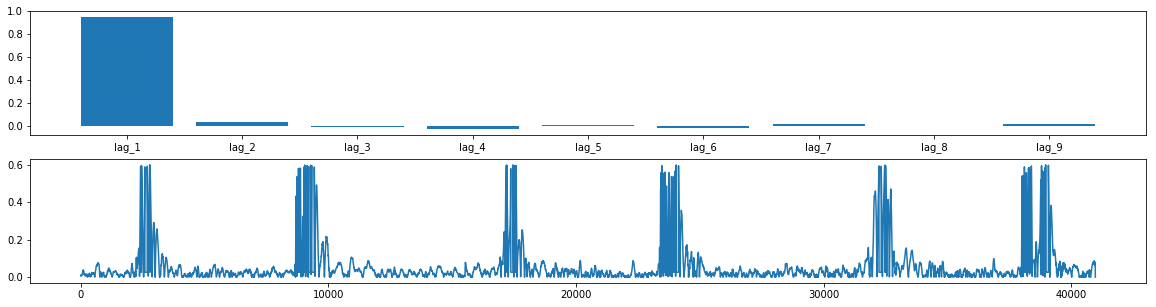

In [303]:
fig,axes=plt.subplots(2,1,figsize=(20,5))
axes[0].bar(many_shifts.columns,model.coef_)
axes[1].plot(audio_half_wave)
#plt.legend()

In [338]:
X,y=many_shifts,audio_half_wave_series
X.shape,y.shape

((40969, 9), (40969,))

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import Ridge
model=Ridge()
cv=ShuffleSplit(10,random_state=1)
results=[]
for tr,tt in cv.split(X,y):
    print(tr,tt)
    model.fit(X[tr],y[tr])
    pred=model.predict(X[tt])
    mae=np.mean(y[tt]-np.sum(pred))
    results.append(pred,mae,tt)

In [347]:
from sklearn.model_selection import TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=3)
a,b,c=cv.split(X,y)
#fig, ax = plt.subplots()
#for i, (tr, tt) in enumerate(cv.split(X,y)):
    #print(y[tr],i+y[tr])
    #ax.plot(tr, i + y[tr])

#ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
#plt.show()

[2 3 1 0 5] [4]
[3 1 4 2 5] [0]
[5 3 2 0 1] [4]
[4 2 0 1 3] [5]
[4 2 1 0 5] [3]
[3 2 0 4 5] [1]
[5 4 2 0 1] [3]
[0 5 2 4 3] [1]
[5 2 0 4 3] [1]
[1 3 0 5 2] [4]


[Text(0.5,0,'Prediction index'),
 Text(0.5,1,'Test set predictions on each CV loop')]

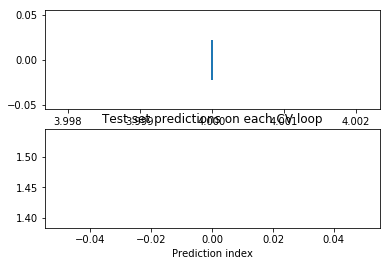

In [335]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import Ridge
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [3, 4], [5, 6]])
y = np.array([1, 2, 1, 2, 1, 2])
model=Ridge()
cv=ShuffleSplit(10)
results=[]
for tr,tt in cv.split(X,y):
    print(tr,tt)
    model.fit(X[tr],y[tr])
    pred=model.predict(X[tt])
    mae=np.mean(y[tt]-np.sum(pred))
    #results.append(pred,mae,tt)

fig, axs = plt.subplots(2, 1)
# Plot the indices chosen for validation on each loop
axs[0].scatter(tt, [0] * len(tt), marker='_', s=2, lw=40)
# Plot the model predictions on each iteration
axs[1].plot(model.predict(X[tt]))
axs[1].set(title='Test set predictions on each CV loop',
xlabel='Prediction index')

C:\Users\Sachin\Anaconda3\lib\site-packages\librosa\core\spectrum.py:960: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


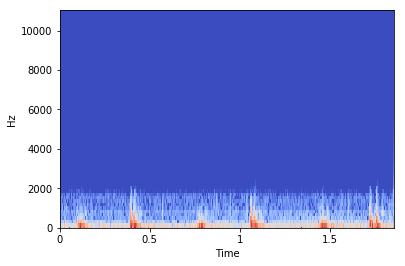

In [180]:
HOP_LENGTH = 2**4
SIZE_WINDOW = 2**7
audio_spec = stft(normal_audio, hop_length=HOP_LENGTH, n_fft=SIZE_WINDOW)
spec_db = amplitude_to_db(audio_spec)
specshow(spec_db, sr=normal_freq, x_axis='time',
         y_axis='hz', hop_length=HOP_LENGTH)



In [189]:
spec_db.shape

(65, 2561)

In [186]:
bandwidths = lb.feature.spectral_bandwidth(S=spec_db>0)[0]
centroids = lb.feature.spectral_centroid(S=spec_db>0)[0]

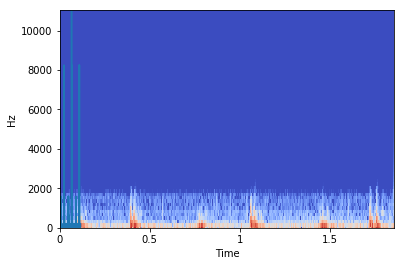

In [193]:
ax=specshow(spec_db, sr=normal_freq, x_axis='time',
         y_axis='hz', hop_length=HOP_LENGTH)
ax.plot(normal_time[:2561],bandwidths)
ax.fill_between(normal_time[:2561], centroids - bandwidths / 2,
centroids + bandwidths / 2, alpha=0.5)